In [1]:
import numpy as np
import tensorflow as tf
import gym
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
env = gym.make('CartPole-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
from collections import deque

class Memory:
    def __init__(self, capacity=50):
        self.memories = deque()
        self.capacity = capacity
        self.n = len(self.memories)
    
    def forget(self):
        self.memories.popleft()
        self.n -= 1
    
    def remember(self, experience):
        self.memories.append(experience)
        self.n += 1
        if len(self.memories) > self.capacity:
            self.forget()
        
    def sample(self, n=1):
        idx = np.random.choice(range(len(self.memories)),n)
        return np.take(self.memories, idx, axis=0)

In [4]:
#--------------------------------
# Neural Network as function approximator (replace Q table)
#--------------------------------
tf.reset_default_graph()

# environment dimensions
s_shape = env.observation_space.shape[0]
a_shape = env.action_space.n

# input placeholder
S = tf.placeholder(tf.float32,[None,s_shape],name='state_input')

# simple mlp with "s_shape" inputs, 20 hidden units, "a_shape" outputs
h=20
w1 = tf.get_variable("W1", [s_shape,h], initializer = tf.keras.initializers.he_normal(seed=1))
b1 = tf.get_variable("B1", [1,h], initializer = tf.keras.initializers.he_normal(seed=1))
z1 = tf.add(tf.matmul(S,w1),b1)
a1 = tf.nn.relu(z1)

w2 = tf.get_variable("W2", [h,a_shape], initializer = tf.keras.initializers.he_normal(seed=1))
b2 = tf.get_variable("B2", [1,a_shape], initializer = tf.keras.initializers.he_normal(seed=1))
Qnet = tf.add(tf.matmul(a1,w2),b2)

# greedy policy wrt learned q values
action = tf.argmax(Qnet,1)

# loss = MSE q value prediction
Qtarget = tf.placeholder(shape=[None,a_shape],dtype=tf.float32)
loss = tf.reduce_mean(tf.square(tf.subtract(Qtarget,Qnet)))
trainer = tf.train.AdamOptimizer()
updateModel = trainer.minimize(loss)

![network_diagram](../diagrams/q_network_img "Q-Network Structure")

In [5]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [6]:
#--------------------------------
# Learning parameters
#--------------------------------
alpha = 0.4
gamma = 0.99
epsilon = 1.0
decay = 0.998

alpha_min = 0.1
epsilon_min = 0.1

In [7]:
n_episodes = 1000
n_actions = env.action_space.n
reward_history = []
experience_replay = Memory(capacity=5000)
minibatches = 32

#--------------------------------
# Iterate through pole balancing episodes
#--------------------------------
for episode in range(n_episodes):

    s = env.reset()
    rsum = 0  
    explore_rate = max(epsilon_min, epsilon*decay**episode)

    #--------------------------------
    # individual steps through a single episode
    #--------------------------------
    while True:
        #--------------------------------
        # Epsilon greedy policy for selecting actions
        #--------------------------------
        s = np.clip(s, -10, 10)
        a = sess.run(action,feed_dict={S:np.atleast_2d(s)})[0]
        if np.random.uniform() < explore_rate:
            a = np.random.choice(range(n_actions))        
        
        #--------------------------------
        # Take selected action
        #--------------------------------
        sp, r, d, _ = env.step(a)
        sp = np.clip(sp, -10, 10)
        experience_replay.remember((s,a,r,sp,d))
        
        #------------------------------------------------------------------------
        # Update Q Network with experience replay minibatches
        #------------------------------------------------------------------------ 
        minibatch = min(experience_replay.n, minibatches)
        batch = experience_replay.sample(minibatch)
        batch_s = batch[:,0]
        batch_a = batch[:,1]
        batch_r = batch[:,2]
        batch_sp = batch[:,3]
        done = batch[:,4]
        
        Q = sess.run(Qnet,feed_dict={S:np.stack(batch_s)})
        Qp = sess.run(Qnet,feed_dict={S:np.stack(batch_sp)})
        for i in range(minibatch):
            if done[i]:
                Q[i,batch_a[i]] = (1-alpha)*Q[i,batch_a[i]] + alpha*(batch_r[i])
            else:
                Q[i,batch_a[i]] = (1-alpha)*Q[i,batch_a[i]] + alpha*(batch_r[i]+gamma*max(Qp[i]))
        
        X = np.stack(batch_s)
        Y = Q
        for _ in range(1):
            _, l = sess.run([updateModel,loss], feed_dict={S:X,Qtarget:Y})
        
        s = sp
        rsum += r
        if d:
            break

    reward_history.append(rsum)
    #--------------------------------
    # Print out progress indicators 
    #--------------------------------
    if episode%50==0:
        print("Episode {}: Avg Reward = {}, Exploration Rate = {:.3f}, Loss = {:.3f}".format(episode,np.mean(reward_history[-50:]),explore_rate,l))

Episode 0: Avg Reward = 14.0, Exploration Rate = 1.000, Loss = 1.221
Episode 50: Avg Reward = 22.14, Exploration Rate = 0.905, Loss = 0.222
Episode 100: Avg Reward = 20.84, Exploration Rate = 0.819, Loss = 0.118
Episode 150: Avg Reward = 22.74, Exploration Rate = 0.741, Loss = 2.253
Episode 200: Avg Reward = 35.34, Exploration Rate = 0.670, Loss = 4.662
Episode 250: Avg Reward = 39.42, Exploration Rate = 0.606, Loss = 0.224
Episode 300: Avg Reward = 45.7, Exploration Rate = 0.548, Loss = 0.155
Episode 350: Avg Reward = 85.08, Exploration Rate = 0.496, Loss = 0.150
Episode 400: Avg Reward = 187.06, Exploration Rate = 0.449, Loss = 0.160
Episode 450: Avg Reward = 214.94, Exploration Rate = 0.406, Loss = 0.179
Episode 500: Avg Reward = 275.3, Exploration Rate = 0.368, Loss = 0.180
Episode 550: Avg Reward = 235.8, Exploration Rate = 0.333, Loss = 0.159
Episode 600: Avg Reward = 408.66, Exploration Rate = 0.301, Loss = 0.028
Episode 650: Avg Reward = 387.26, Exploration Rate = 0.272, Loss =

In [8]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

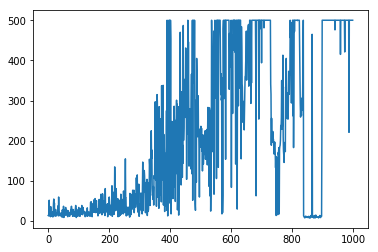

In [9]:
plt.plot(reward_history)

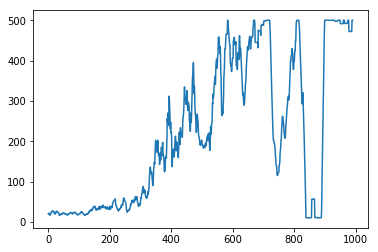

In [10]:
rmoving = running_mean(reward_history, 10)
plt.plot(rmoving)

---
## Run your trained agent for a random episode!

---

In [11]:
s = env.reset()
total_reward = 0
while True:
    a = sess.run(action,feed_dict={S:np.atleast_2d(s)})[0]
    sp, r, d, _ = env.step(a)
        
    env.render()

    total_reward += r
    s = sp
    if d:
        print(total_reward)
        break

500.0
